In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Coin flipping with a continuous prior 

In this example, we revisit the coin flipping example but now we will consider a continuous distribution for the $\theta$ parameter. This will require us to use a different approach.

### 1. Model formulation

Same as before, our model has two random variables, but we will make some simplifications. The number of tosses in specified in advance $\#tosses$, so that for one experiment we only have to specify the number of heads:

$\#heads$: random variable representing the number of heads in a sequence of coin tosses.

$\theta$: probability of getting a head 

The probability of a particular experiment outcome is given by the binomila distribution:

$$
\begin{align}
P(\#heads\ |\ \theta) &= \binom{\#tosses}{\#heads} \theta^{\#heads}(1 - \theta)^{\#tosses - \#heads}
\end{align}
$$

This term is called the *likelihood*, the conditional probability of the data given the parameters.

For modeling the *prior* we will use a beta distribution. 

$$
P(\theta) = \text{Beta}(2,2)
$$

The following code plots the prior with the help of TF Probability

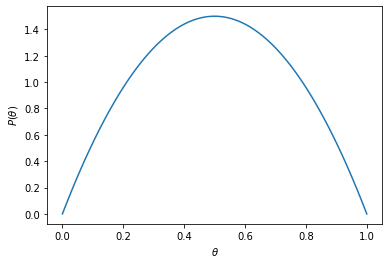

In [58]:
import tensorflow_probability as tfp
tfd =  tfp.distributions

import numpy as np
import matplotlib.pyplot as plt


def theta_prior_fun():
    return tfd.Beta(2,2).prob

    
theta_prior = theta_prior_fun()
theta_vals = np.linspace(0, 1, 100)
theta_p = [theta_prior(val) for val in theta_vals]
ax = plt.subplot()
plt.plot(theta_vals, theta_p)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$P(\theta$)');

Instead of modeling the prior and the likelihood separately, we will model them jointly. Remember that:

$$
P(\#heads, \theta) = P(\#heads | \theta)P( \theta)
$$

So, we will use `tfd.JointDistributionSequential` to model this joint probability. `JointDistributionSequential` allows us to specify the dependencies among our random variables along with their corresponding distributions. 

In [9]:
def create_joint_distribution(num_tosses):
    joint = tfd.JointDistributionSequential([
                       tfd.Beta(2, 2),                                   # theta
        lambda  theta: tfd.Binomial(total_count=num_tosses, probs=theta) # num_heads
    ], batch_ndims=0) #, use_vectorized_map=True)
    return joint


We can use a `JointDistributionSequential` object to draw samples from the joint probability distribution, as well as for calculating the unnomarlized probability of a sample. 

In [60]:
# Creates a joint distribution object for 10 tosses
jd = create_joint_distribution(10) 

# Draws 5 samples
sample = jd.sample(5)

print(f'Theta vals:{sample[0].numpy()}')
print(f'#heads vals:{sample[0].numpy()}')

# Calculate the log probability of this samples
prob = jd.log_prob(sample)
print(f'Log probabilities:{prob.numpy()}')

# Draws a plot of the joint probability for #heads = 6


Theta vals:[0.5571841  0.2368055  0.56320196 0.15977305 0.7668681 ]
#heads vals:[0.5571841  0.2368055  0.56320196 0.15977305 0.7668681 ]
Log probabilities:[-1.487639  -1.4891112 -1.0213742 -1.4703302 -1.3688765]


## 2. Data collection

Two collect data we can toss a real coin a number of times and record how many 
heads ($\# heads$) and tails ($\# tails$) we get. This is our data $D$. For this exercise let's assume we got  $\# heads = 15$ out of $\#tosses = 20$.

## 3. Posterior calculation

Instead of calculating explicitely the posterior ($P(\theta|\#heads)$) we will draw samples from it with the help of a MCMC sampler. To do so we need to first define the target log probability function. This function will depend only on $\theta$ which is the variable that we will sample. 

In [62]:
num_tosses = 20
jd = create_joint_distribution(num_tosses) 

num_heads = np.array([15])

def target_log_prob_fn(theta):
  """Unnormalized target density as a function of states."""
  return jd.log_prob((
      theta, num_heads))

It is important to remember that we are modeling the joint probability $P(\#heads,\theta)$ which is proportional to $P(\theta|\#heads)$ since:

$$
P(\theta|\#heads) = \frac{P(\#heads,\theta)}{P(\#heads)}
$$

We can think of the joint as an unnormalized posterior. Let's plot this unnormalized posterior for different values of $theta$, to get an idea of how the real posterior looks like:

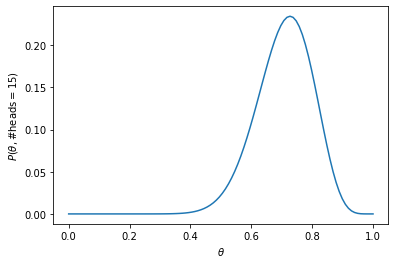

In [68]:
theta_vals = np.linspace(0, 1, 100)
theta_unnorm_posterior = [np.exp(target_log_prob_fn(val)) for val in theta_vals]
ax = plt.subplot()
plt.plot(theta_vals, theta_unnorm_posterior)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$P(\theta,$#heads$=15})$)');

Notice that the distribution is skewed towards the right.

Now we can draw samples with the help of MCMC

In [69]:
num_results = 50000
num_burnin_steps = 3000

# Improve performance by tracing the sampler using `tf.function`
# and compiling it using XLA.
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.constant([0.5], name='init_avg_effect'),
      ],
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=target_log_prob_fn,
          step_size=0.05,
          num_leapfrog_steps=3))

states, kernel_results = do_sampling()
num_accepted = np.sum(kernel_results.is_accepted)
print('Acceptance rate: {}'.format(num_accepted / num_results))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 0.9743


Now we can plot a histogram of the obtained samples, that can be used as an empirical distribution. 

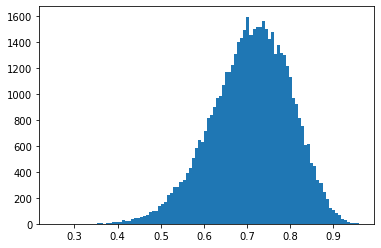

In [70]:
plt.hist(states[0].numpy(), bins=100);

Now we call the function with our data and plot the resulting posterior distribution:

## 4. Model application

We can use the set of samples, $\{\theta_i\}_{i=1\dots N}$, to calculate summarizations of the posterior distribution. For instance to calculate the Bayes estimators, we can approximate it by averaging the samples:


$$
\theta_{\text{Bayes}} = E[\theta] \approx \frac{1}{N}\sum_{i=1}^N \theta_i
$$


In [71]:
def bayes_estimator(samples):
    return np.average(samples)

print(f'Bayes estimator:{bayes_estimator(states[0].numpy())}')


Bayes estimator:0.708452582359314
